In [11]:
import mapplotting
import xarray
import numpy as np
from matplotlib import pyplot as plt
import cartopy
import matplotlib
import dictionaries
import matplotlib.colors as colors
import geopandas as gp
from copy import copy
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

S_lim = 53.5
N_lim = 60
W_lim = 10
E_lim = 20

pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))
# to create histograms, run python3 create_histogram.py

In [12]:
def plot_concentrations_map(fig, ax, bathy=True, cbar=True, labels=True, zoomin=False, gtrajectory=True,
    gridlines=True, biglabels=True):
    import matplotlib.ticker as mticker

    if zoomin:
        S_lim = 54.7
        N_lim = 56.6
        W_lim = 12.5
        E_lim = 17.5
    else:
        S_lim = dictionaries.S_lim
        N_lim = 56.6
        #N_lim = dictionaries.N_lim#57 # dictionaries.N_lim # 57
        W_lim = dictionaries.W_lim
        E_lim = dictionaries.E_lim

    leak1 = dictionaries.leak1
    leak2 = dictionaries.leak2
    leak3 = dictionaries.leak3
    leak4 = dictionaries.leak4

    pc = cartopy.crs.PlateCarree()
    #ax.set_facecolor('#00022e')
    #ax.set_facecolor('azure')
    ax.set_extent((W_lim, E_lim, S_lim, N_lim), crs=pc)

    feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                           scale='10m', edgecolor='black', facecolor='burlywood',
                                           zorder=2)


    for leak in [leak1, leak2, leak3, leak4]:
        ax.scatter(leak['lon'], leak['lat'], color='orange', transform=pc, s=150, zorder=20,
                    edgecolor='k', marker="X")

    ax.add_feature(feature)
    ax.add_feature(cartopy.feature.LAKES, alpha=1, zorder=1)
    gl = ax.gridlines(draw_labels=True,
                      linewidth=1, alpha=1, color='darkgrey', linestyle='--', zorder=40)
    gl.top_labels = None
    gl.right_labels = None
    if not labels:
    	gl.left_labels = None

    if zoomin:
        gl.xlocator = mticker.FixedLocator([13, 17])
    else:
        gl.xlocator = mticker.FixedLocator([10, 20])

    if biglabels:
        gl.ylabel_style = {'size': 18, 'color':'k'}
        gl.xlabels_top = True
        gl.xlabels_bottom = False
        gl.xlabel_style = {'size':18, 'color':'k', 'rotation':0}

    if gridlines:
        gl2 = ax.gridlines(draw_labels=False,
                       linewidth=1, alpha=1, color='darkgrey', linestyle='--', zorder=40)

    return pc, ax, gl


def plot_helcom(ax, df_helcom):
    """"""
    acolors = []
    for area in range(0,len(df_helcom)):
        acolors.append(np.random.rand(3,))

    crs = cartopy.crs.AzimuthalEquidistant()
    crs_proj4 = crs.proj4_init
    df_helcom = df_helcom.to_crs(crs_proj4)
    ax.add_geometries(df_helcom.sort_values('Shape_Area', ascending=False).geometry,
                      crs=crs,
                      zorder=1,
                      edgecolor='k',
                      linewidth=2,
                      #color=acolors,
                      facecolor=(1,1,1,0))
    return ax

def plot_pipelines(ax):
    import geopandas

    nybb = geopandas.read_file('/home/coffee/VOTO/data/Nordstream/_ags_Pipelines_2018/Pipelines_2018.shp')

    alltraj = nybb.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'}).geometry
    alltraj = alltraj.to_list()
    Nordstream1 = alltraj[4]
    Nordstream2 = alltraj[5]
    N2lons = np.array(Nordstream2.coords.xy[0])
    N2lats = np.array(Nordstream2.coords.xy[1])
    mask = ((N2lons<14.6) | (N2lons>15.6))
    N1lons = Nordstream1.geoms[1].coords.xy[0]
    N1lats = Nordstream1.geoms[1].coords.xy[1]

    ax.plot(np.where(mask, N2lons, np.nan),
            np.where(mask, N2lats, np.nan),
            transform=ccrs.PlateCarree(),
            color='darkgrey',
            zorder=1,
            lw=5,
            alpha=1)

    ax.plot([15.775656, 15.80 ,15.41, 15.3, 14.5],
            [55.506924, 55.3,54.876667, 54.8, 54.564],
            transform=ccrs.PlateCarree(),
            color='darkgrey',
            zorder=1,
            lw=7,
            alpha=1)

    ax.plot(N1lons, N1lats,
            transform=ccrs.PlateCarree(),
            color='darkgrey',
            zorder=1,
            lw=7,
            alpha=1)


def plot_glider_data_tail(ax, means, enddate, vmin, vmax):
    means4 = means.where((means.time<enddate) & (means.time>enddate-np.timedelta64(6,'D')))

    if not np.isnan(means4['latitude']).all():
        mcolor = ax.scatter(
            means4['longitude'],
            means4['latitude'],
            c='k',
            transform=ccrs.PlateCarree(),
            s=20,
            zorder=16,
            cmap='Reds')

        mcolor = ax.scatter(
            means4['longitude'],
            means4['latitude'],
            c=means4['Methane_tempcorr']*1e-3,
            transform=ccrs.PlateCarree(),
            norm=matplotlib.colors.LogNorm(
               vmin=vmin,
               vmax=vmax),
            s=15,
            zorder=16,
            cmap='Reds')

        for marker in ["$0x25B2$",
                       "$\u2B2E$"]:
            ax.scatter(
                means4['longitude'].dropna().iloc[-1], # maxs4['longitude'][-1],
                means4['latitude'].dropna().iloc[-1], # maxs4['latitude'][-1],
                #c='tab:blue',
                transform=ccrs.PlateCarree(),
                s=300,
                zorder=101,
                marker=marker,
                color='yellow',
                edgecolors='k')

In [13]:
def create_map_figure(fig, ax, zoomin=False, cbar=False):
    pc, ax, gl = plot_concentrations_map(fig, ax, bathy=False, 
                                                     zoomin=zoomin, 
                                                     cbar=False,
                                                     gtrajectory=True,
                                                     biglabels=False)
    return fig, ax, pc, gl

In [14]:
bathy = xarray.open_dataset("../data/input/BAL-MFC_003_006_mask_bathy.nc")
bathy = bathy#.sel(longitude=slice(10,20), latitude=slice(53,60.02), drop=True)
coordinates = xarray.open_dataset("../data/input/BAL-MFC_003_006_coordinates.nc")
coordinates['areas'] = coordinates.e1t*coordinates.e2t
coordinates['volumes'] = coordinates.e3t*coordinates.e2t*coordinates.e1t
subbasins = 'level_2'
mask = bathy['mask'].values.astype(int)
np.shape(coordinates['volumes'].values)
coordinates['volumes'] = coordinates['volumes'].where(mask)

ds = xarray.open_mfdataset('../data/output/100_histogram.nc', chunks=dict(time=1000, z_bin=10))
ds = ds.isel(time=slice(0,-1,1), drop=True) # use this for speedup or approximation

volumes = coordinates['volumes'].rename(
    dict(
        latitude='lat_bin', 
        longitude='lon_bin',
        depth='z_bin'))
ds['volumes'] = (('z_bin', 'lat_bin', 'lon_bin'), volumes.values) # keep this way!
ds['concentration'] = ds.mass/ds.volumes # [in ug/m3]
ds['concentration'] = ds['concentration']*1e-6/16.04*1e-3#*1e9
ds['concentration_zmean'] = ds['mass_zsum']*1e-6/16.04*1e-3/ds.volumes.sum(dim='z_bin')#*1e9

In [15]:
mode = 'column_avg_maximum_exposure'#'maximum_exposure' # 'one_timestep'
if mode == 'one_timestep':
    dss = ds.sel(
                 time=np.datetime64('2022-10-15T12'), 
                 method='nearest'
                ).mean(dim='z_bin')
elif mode == 'maximum_exposure':
    dss = ds['concentration'].max(dim=['time', 'z_bin'])#*1e9
elif mode == 'column_avg_maximum_exposure':
    # dss = ds.
    dss = ds['concentration_zmean'].max(dim='time')#*1e9

In [16]:
dss = dss.compute() # this is good actually, because then dss does not has to be recomputed mutliple times below

In [17]:
def create_3a(fig, ax):
    fig, ax, pc, gl = create_map_figure(fig, ax)

    #feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
    #                                       scale='10m', edgecolor='black', facecolor='burlywood',
    #                                       zorder=1000)
    #ax.add_feature(feature)

    
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.xlabel_style = {'color':'k', 'rotation':0}
    vmin=1#1e-9
    vmax=1e6#1e-3

    #bounds = np.linspace(1, 30000)
    bounds = [1,10,100,1000,10000]
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
    colors0 = ax.pcolormesh(dss.lon_bin,
                  dss.lat_bin,
                  dss.T*1e9,
                  transform=pc,
                  norm=norm, #matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'),
                  #norm=matplotlib.colors.LogNorm(
                  #          vmin=vmin,
                  #          vmax=vmax
                  #),
                #zorder=3
                  cmap='Reds',
                  zorder=0)

    cb = fig.colorbar(colors0, ax=ax, orientation='vertical', 
                      label='Methane conc. [nM]', 
                      shrink=0.6, 
                      extend='both')   


In [18]:
def create_3b(fig, axs, MPA=False, threshold=10):#, threshold = 10):#e-9):#5e-9):
    import pandas
    if MPA:
        meanconctable = pandas.read_csv('../code/meanconctableMPA.csv')
        maxconctable = pandas.read_csv('../code/maxconctableMPA.csv')
    else:
        meanconctable = pandas.read_csv('../code/meanconctable.csv')
        maxconctable = pandas.read_csv('../code/maxconctable.csv')
    meanconctable = meanconctable.set_index('time')*1e9
    maxconctable = maxconctable.set_index('time')*1e9
    # import pdb; pdb.set_trace();
    maxconctable = maxconctable.drop('Ocean region w. no mask', axis=1)
    meanconctable = meanconctable.drop('Ocean region w. no mask', axis=1)
    
    keys = meanconctable.T.loc[(meanconctable.T>=threshold).any(axis=1)].index
    print(f"found {len(keys)} areas with mean values higher than {threshold}")
    A = pandas.concat([meanconctable[list(keys)], 
                       maxconctable[list(keys)]], 
                      axis=1).sort_index(axis=1).T
    # fig, axs = plt.subplots(nrows=len(np.unique(A.index)))
    
    for i,basin in enumerate(np.unique(A.index)):
        print(basin)

        bounds = [1,10,100,1000,10000]
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

        cc = axs[i].pcolormesh(pandas.to_datetime(A.T.index), np.array([0,1]),
            A.loc[basin],
        norm=norm,#matplotlib.colors.LogNorm(vmin=1., vmax=1.e6),#1e-9, vmax=1e-3),
        cmap='Reds',
        )
        """
        for hdict in dictionaries.hatchesdicts:
            redtable = A.loc[basin][(A.loc[basin]>hdict['vmin']) & (A.loc[basin]<hdict['vmax'])]
            hatchbar = axs[i].pcolor(
                   pandas.to_datetime(A.T.index), np.array([0,1]),
                   #redtable.columns,
                   #redtable.index,
                   redtable,
                   hatch=hdict['hatch'], 
                   alpha=0.)
        """

        axs[i].set_yticks([1])
        if MPA:
            cutofflength = 25 # cut too long MPA names
            if len(basin)>25:
                bname = basin[0:25]+'.'
            else:
                bname = basin
            bname = bname+' ('+str(i+1)+')'
        else:
            bname = basin.replace('Western', 'W.')
            bname = bname.replace('Eastern', 'E.')
            #import pdb; pdb.set_trace()
        axs[i].set_yticklabels([bname])
        if i<len(np.unique(A.index))-1:
            axs[i].set_xticks([])
        
    cb = fig.colorbar(cc, ax=axs, label='Methane conc. [nM]', extend='both')

    #patches = [dict(mini=5e-9, maxi=5e-8, hatch)]
    """
    for hatch in dictionaries.hatchesdicts:
        cb.ax.add_patch(
            matplotlib.patches.Rectangle((0,hatch['vmin']), 
                                  10, 
                                  hatch['spacing']*hatch['vmin'],
                                  color='k', 
                                  hatch=hatch['hatch'],
                                  fill=False, 
                                  snap=True))   
    """

    #ax.set_y
    return keys

found 23 areas with mean values higher than 10
Adler Grund og Rønne Banke
Bakkebrædt og Bakkeground
Bornholm: Davids Banke
Bornholm: Ertholmene
Darßer Schwelle
Falsterbo Peninsula with Måkläppen
Greifswalder Bodden und Strelasund
Hvideodde Rev
Jasmund National Park
Klinteskov Kalkgrund
Lawica Slupska
Northern Midsjöbanken
Ostoja Slowinska
Plantagenetgrund, Libben, Steilküste und Blockgründe Wittow, Arkona und Jasmund
Pommersche Bucht-Rönnebank
Przybrzezne Wody Baltyku
Torhamns Archipelago
Ujscie Wisly
Vorpommersche Boddenlandshaft National Park (West-Pommeranian Lagoon National Park)
Värnanäs Archipelago
Wolin i Uznam
Zatoka Pomorska
Zatoka Pucka


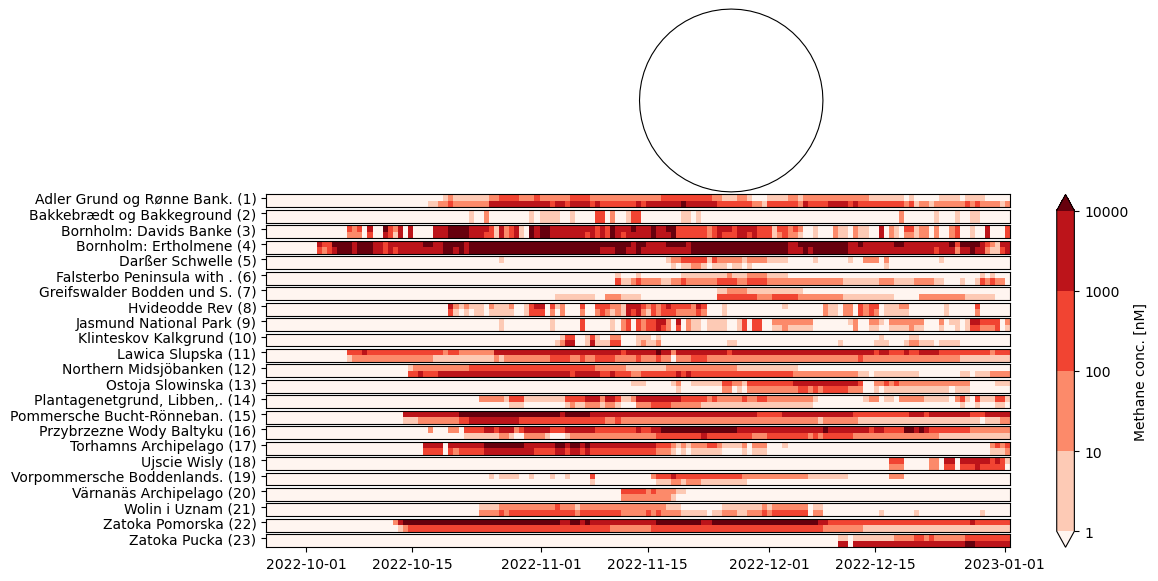

In [19]:
# this cell exists to create the "MPAkeys" variable. No output
pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))

fig = plt.figure(figsize=[12,10])
gs = fig.add_gridspec(nrows=50)
ax0 = fig.add_subplot(gs[0:12], projection=coord)
axs = [fig.add_subplot(gs[i:i+1]) for i in range(12,35)]
MPAkeys = create_3b(fig, axs, MPA=True, threshold=10)
MPAkeys = MPAkeys.sort_values()

found 5 areas with mean values higher than 10
Arkona Basin
Bornholm Basin
Eastern Gotland Basin
Gdansk Basin
Western Gotland Basin


/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


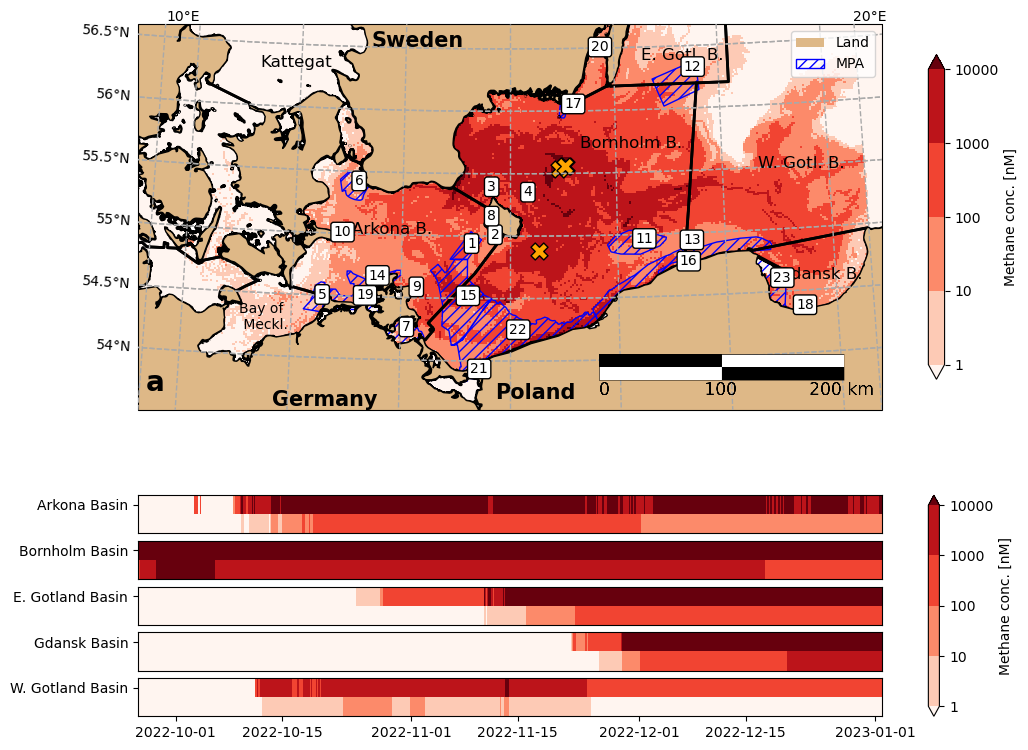

In [20]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


S_lim = 53.5
N_lim = 60
W_lim = 10
E_lim = 20
pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))

fig = plt.figure(figsize=[12,10])
gs = fig.add_gridspec(nrows=17)
ax0 = fig.add_subplot(gs[0:12], projection=coord)
# I need some axes for my double pcolormesh mean/max plot
axs = [fig.add_subplot(gs[i:i+1]) for i in range(12,17)]
#ax0.set_title('overview map')
#ax1.text(0.5, 0.5, "Glider section", va="center", ha="center")
#ax1.set_title("Ferrybox Hovmöller")
create_3b(fig, axs)

### !!! for some reason it matters to create the map last !!! otherwise no show ### 
create_3a(fig, ax0)
ax0.text(11.8,53.6,'Germany',fontsize=15,weight='bold', transform=cartopy.crs.PlateCarree())
ax0.text(14.8,53.7,'Poland',fontsize=15,weight='bold', transform=cartopy.crs.PlateCarree())
ax0.text(13,56.5,'Sweden',fontsize=15,weight='bold', transform=cartopy.crs.PlateCarree())

ax0.text(12.8,55.0,'Arkona B.',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(16.,55.7,'Bornholm B.',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(16.9,56.4,'E. Gotl. B.',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(18.5,55.5,'W. Gotl. B.',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(18.7,54.6,'Gdansk B.',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(11.3,54.2,'Bay of \n Meckl.',fontsize=10, transform=cartopy.crs.PlateCarree(), zorder=200)
ax0.text(11.4,56.3,'Kattegat',fontsize=12, transform=cartopy.crs.PlateCarree(), zorder=200)

ax0.text(0.01, 0.05, 'a', transform=ax0.transAxes, 
         size=20, weight='bold', zorder=100)

# Basins
df_helcom = gp.read_file("../data/input/_ags_HELCOM_subbasins_2022_level21/HELCOM_subbasins_2022_level2.shp")
plot_helcom(ax0, df_helcom)

# MPAs
#import adjustText as aT
df_helcom = gp.read_file("../data/input/_ags_HELCOM_MPAs_2019_2/HELCOM_MPAs_2019_2.shp")
crs = cartopy.crs.AzimuthalEquidistant()
crs_proj4 = crs.proj4_init
df_helcom = df_helcom.to_crs(crs_proj4)
df_helcom = df_helcom[df_helcom['Name'].isin(list(MPAkeys))]
df_helcom = df_helcom.sort_values(by='Name')

ax0.add_geometries(df_helcom.geometry,#df_helcom.sort_values('Shape_Area', ascending=False).geometry,
                  crs=crs,
                  zorder=0,
                  hatch='///',
                  edgecolor='blue',
                  linewidth=1,
                  alpha=1.0,
                  #color=acolors,
                  facecolor='None',
                  label='MPA')#(1,1,1,0))

df_helcom["center"] = df_helcom["geometry"].centroid
df_helcom_points = df_helcom.copy()
df_helcom_points.set_geometry("center", inplace = True)
df_helcom_points = df_helcom_points.to_crs({'proj':'longlat', 'ellps':'WGS84', 'datum':'WGS84'}).geometry

for i in range (0, len(df_helcom_points)):
    if i==11:
        offsetx=0.1
        offsety=0.1
    elif i==12:
        offsetx=0.1
        offsety=0.2
    else:
        offsetx=0.0
        offsety=0.0
    point = df_helcom_points.iloc[i]
    label = df_helcom.iloc[i].Name
    ax0.text(x=point.x+offsetx, 
             y=point.y+offsety,
             s=str(i+1),
             transform=cartopy.crs.PlateCarree(),
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'),
             zorder=200)
#ax.text(0.5, 0.2, 'Test', color='black', 
#        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
#texts = []
#for x, y, label in zip(df_helcom_points.geometry.x, df_helcom_points.geometry.y, df_helcom_points["Name"]):
#    texts.append(ax0.text(x, y, label, fontsize = 8))

#aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
#               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
red_patch = Patch(label='MPA', facecolor='None', hatch='///', edgecolor='blue',linewidth=1,)
land_patch = Patch(facecolor='burlywood', label='Land', )#hatch='////'),)


legend_elements = [
    Patch(facecolor='burlywood', label='Land', ),
    Patch(label='MPA', facecolor='None', hatch='///', edgecolor='blue',linewidth=1,),
]
"""
    Patch(facecolor='burlywood', #edgecolor='blue',
                     label='Land', ),#hatch='////'),
    Patch(facecolor='lavender',
                     label='Sea (<50 m deep)'),
    Patch(facecolor='lightsteelblue', 
                     label='Sea (>50 m deep)',) #hatch='////')
]
"""

#plt.legend(handles=legend_elements, loc="upper right").set_zorder(50)
#plt.legend(handles=[red_patch])

arr_img = plt.imread("../figures/scalebar4.png")
im = OffsetImage(arr_img, zoom=.2)
#ab = AnnotationBbox(im, (0.2, 0.88), xycoords='axes fraction', box_alignment=(0,0), frameon=False)
#ax0.add_artist(ab).set_zorder(200)
ab1 = AnnotationBbox(im, (0.62, 0.02), xycoords='axes fraction', box_alignment=(0,0), frameon=False)
ax0.add_artist(ab1).set_zorder(200)


ax0.legend(handles=legend_elements, loc="upper right").set_zorder(50)
plt.savefig('../figures/rf_Figure3.pdf', transparent=True, dpi=300)

In [21]:
#df_helcom = df_helcom[df_helcom['Name'].isin(list(MPAkeys))]
#df_helcom.sort_values(by='Name')#(axis=1).T
#df_helcom

In [12]:

!pwd

/media/coffee/T7/Nordstream/code_public


In [13]:
"""
plt.subplots()

legend_elements = [
    Patch(facecolor=(1,1,1,0), edgecolor='blue',
                     label='MPA', hatch='////'),
    Patch(facecolor='burlywood', #edgecolor='blue',
                     label='Land', ),#hatch='////'),
    Patch(facecolor='lavender',
                     label='Sea (<50 m deep)'),
    Patch(facecolor='lightsteelblue', 
                     label='Sea (>50 m deep)',) #hatch='////')
]

plt.legend(handles=legend_elements, loc="upper right").set_zorder(50)
"""

'\nplt.subplots()\n\nlegend_elements = [\n    Patch(facecolor=(1,1,1,0), edgecolor=\'blue\',\n                     label=\'MPA\', hatch=\'////\'),\n    Patch(facecolor=\'burlywood\', #edgecolor=\'blue\',\n                     label=\'Land\', ),#hatch=\'////\'),\n    Patch(facecolor=\'lavender\',\n                     label=\'Sea (<50 m deep)\'),\n    Patch(facecolor=\'lightsteelblue\', \n                     label=\'Sea (>50 m deep)\',) #hatch=\'////\')\n]\n\nplt.legend(handles=legend_elements, loc="upper right").set_zorder(50)\n'

found 23 areas with mean values higher than 10
Adler Grund og Rønne Banke
Bakkebrædt og Bakkeground
Bornholm: Davids Banke
Bornholm: Ertholmene
Darßer Schwelle
Falsterbo Peninsula with Måkläppen
Greifswalder Bodden und Strelasund
Hvideodde Rev
Jasmund National Park
Klinteskov Kalkgrund
Lawica Slupska
Northern Midsjöbanken
Ostoja Slowinska
Plantagenetgrund, Libben, Steilküste und Blockgründe Wittow, Arkona und Jasmund
Pommersche Bucht-Rönnebank
Przybrzezne Wody Baltyku
Torhamns Archipelago
Ujscie Wisly
Vorpommersche Boddenlandshaft National Park (West-Pommeranian Lagoon National Park)
Värnanäs Archipelago
Wolin i Uznam
Zatoka Pomorska
Zatoka Pucka


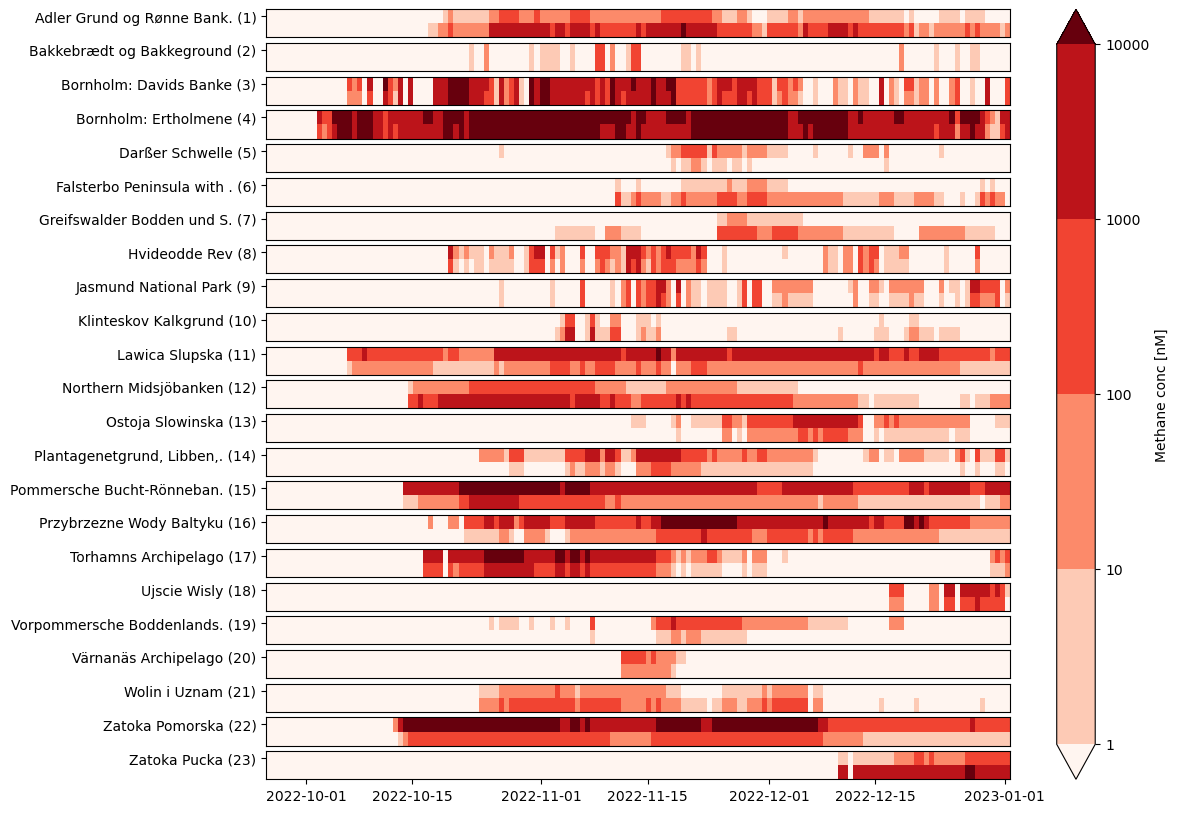

In [14]:
# fig, axs = plt.subplots(nrows=2)
fig = plt.figure(figsize=[12,10])
nrows = 23
gs = fig.add_gridspec(nrows=nrows)
axs = [fig.add_subplot(gs[i:i+1]) for i in range(0,nrows)]
keys = create_3b(fig, axs, MPA=True, threshold=10)
#fig.tight_layout()
#fig.subplots_adjust(left=0.1)
# plt.margins(x=8000)
plt.savefig('../figures/rf_Figure3MPAs.svg', transparent=True, dpi=300)
#plt.tight_layout()
#df_helcom.se
#plt.savefig('../figures/figMPAsuppl.png', dpi=300)
#keys
#df_helcom = gp.read_file("../data/input/_ags_HELCOM_MPAs_2019_2/HELCOM_MPAs_2019_2.shp")
#df_helcom


In [15]:
#df_helcom[df_helcom['Name'].isin(list(keys))]
#keys

In [16]:
#import pandas
#meanconctable = pandas.read_csv('./meanconctableMPA.csv')
#meanconctable*2

/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/coffee/micromamba/envs/analysis/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


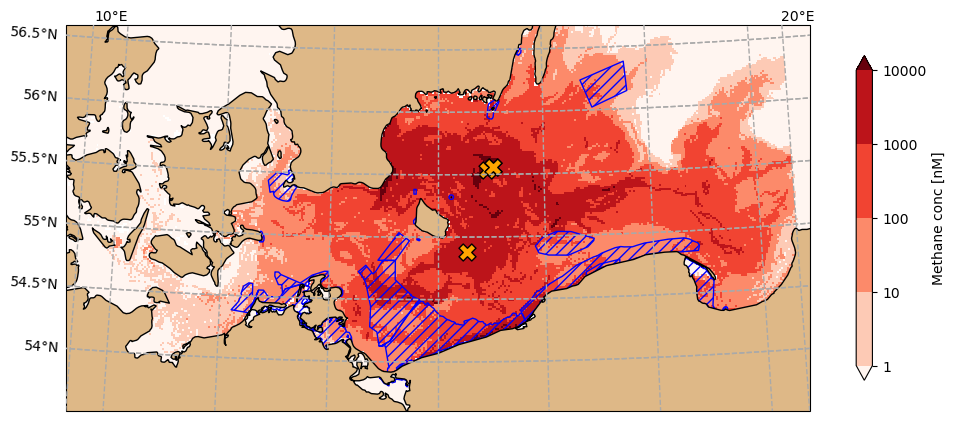

In [17]:
#fig, ax = plt.subplots()
from matplotlib import pyplot as plt
#fig, ax = plt.subplots()

pc = cartopy.crs.PlateCarree()
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean((W_lim, E_lim)),
                                  central_latitude=np.mean((S_lim, N_lim)))

fig = plt.figure(figsize=[12,10])
gs = fig.add_gridspec(nrows=17)
ax0 = fig.add_subplot(gs[0:12], projection=coord)

fig, ax, pc, gl = create_map_figure(fig, ax0)

#feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
#                                       scale='10m', edgecolor='black', facecolor='burlywood',
#                                       zorder=1000)
#ax.add_feature(feature)


gl.xlabels_top = True
gl.xlabels_bottom = False
gl.xlabel_style = {'color':'k', 'rotation':0}
vmin=1#1e-9
vmax=1e6#1e-3

cmap = matplotlib.cm.Reds

#fig = plt.figure(figsize=[12,10])
#gs = fig.add_gridspec(nrows=17)
#ax0 = fig.add_subplot(gs[0:12], projection=coord)
bounds = [1,10,100,1000,10000]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
colors0 = plt.pcolormesh(dss.lon_bin,
              dss.lat_bin,
              dss.T*1e9,
              transform=pc,
              norm=norm, #matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'),
              #norm=matplotlib.colors.LogNorm(
              #          vmin=vmin,
              #          vmax=vmax
              #),
              cmap='Reds',
              zorder=0)
cb = fig.colorbar(colors0, ax=ax, orientation='vertical', 
                  label='Methane. conc [nM]', 
                  shrink=0.6, 
                  extend='both')   

ax0.add_geometries(df_helcom.sort_values('Shape_Area', ascending=False).geometry,
                  crs=crs,
                  zorder=0,
                  hatch='///',
                  edgecolor='blue',
                  linewidth=1,
                  alpha=1.0,
                  #color=acolors,
                  facecolor='None')

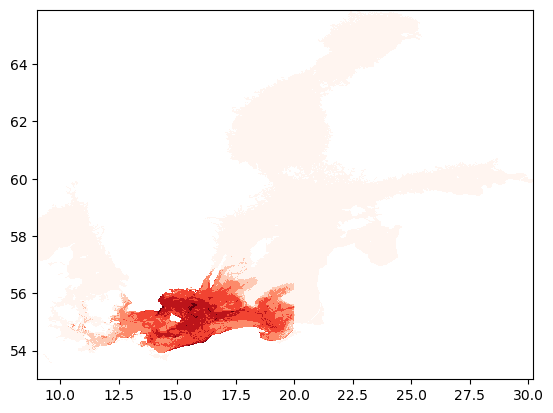

In [17]:
# With out-of-bounds colors:
import matplotlib.colors as colors
bounds = [1,10,100,1000,10000]#np.linspace(1, 30000)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
plt.pcolormesh(dss.lon_bin,
              dss.lat_bin,
              dss.T*1e9,
              #transform=pc,
              norm=norm, #matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both'),
              #norm=matplotlib.colors.LogNorm(
              #          vmin=vmin,
              #          vmax=vmax
              #),
              cmap='Reds',
              zorder=2)